In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import math
import warnings
from tqdm import tqdm
import random
import os
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.manifold import TSNE
import seaborn as sns
import nltk
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
warnings.filterwarnings("ignore")
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from torch.optim.lr_scheduler import (CosineAnnealingWarmRestarts, CosineAnnealingLR, 
                                      ReduceLROnPlateau)

from transformers import (AutoModel, AutoTokenizer, 
                          AutoModelForSequenceClassification,get_constant_schedule_with_warmup)

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow_addons.optimizers import CyclicalLearningRate

In [2]:
config = {
    'batch_size':128,
    'max_len':256,
    'seed':2,
}

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])

In [3]:
#import data
data_variants = pd.read_csv('../input/cancerdata/training_variants')
data_text =pd.read_csv("../input/cancerdata/training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
cleaned_text_data = pd.read_csv('../input/textcolv2/textcol_new.csv')

test_data_variants = pd.read_csv('../input/testdatamsk/stage2_test_variants.csv')
test_data_text =pd.read_csv("../input/testdatamsk/stage2_test_text.csv",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)
cleaned_test_text_data = pd.read_csv('../input/testtextcolcsv/test_textcol_new.csv')

In [4]:
all_data = pd.merge(data_variants, data_text,on='ID', how='left')
all_data.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [5]:
test_data = pd.merge(test_data_variants, test_data_text,on='ID', how='left')
test_data.head()

,ID,Gene,Variation,TEXT
0,1,CHEK2,H371Y,The incidence of breast cancer is increasing i...
1,2,AXIN2,Truncating Mutations,An unselected series of 310 colorectal carcino...
2,3,WNT4,E216G,Mycosis fungoides and Sézary syndrome are prim...
3,4,SUCLA2,G118R,Regulated progression through the cell cycle ...
4,5,BRAF,T599insTT,Pilocytic astrocytoma (PA) is emerging as a tu...


In [6]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         3321 non-null   int64 
 1   Gene       3321 non-null   object
 2   Variation  3321 non-null   object
 3   Class      3321 non-null   int64 
 4   TEXT       3316 non-null   object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [7]:
all_data['Class'].value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

### Preprocessing and Imputation

In [8]:
def initial_clean(text):
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')

def remove_stop_words(text):
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    if type(text) is not float:
        return ' '.join(stem_words(remove_stop_words(initial_clean(text))))
    else:
        return text

In [9]:
all_data['TEXT'] = cleaned_text_data['TEXT']
test_data['TEXT'] = cleaned_test_text_data['TEXT']

In [10]:
all_data[all_data['TEXT'].isnull()]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [11]:
test_data[test_data['TEXT'].isnull()]

,ID,Gene,Variation,TEXT


In [12]:
from nltk.corpus import stopwords
from string import punctuation
from gensim import corpora, models, similarities 

def LDA(gen, var):
    h = all_data[(all_data['Gene']==gen) | (all_data['Variation']==var)]['TEXT'].values
    corpus = [x for x in h if str(x) != 'nan']
    stoplist = stopwords.words('english') + list(punctuation)
    texts = [[word for word in str(document).lower().split() if word not in stoplist] for document in corpus]
    dictionary = corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    tfidf = models.TfidfModel(corpus)
    corpus_tfiall_data = tfidf[corpus] 
    total_topics = 2
    lda = models.LdaModel(corpus, id2word=dictionary, num_topics=total_topics)
    corpus_lda = lda[corpus_tfiall_data]
    k = lda.show_topics(total_topics,100)
    return k
def final_text(gen,var):
    h = LDA(gen,var)
    reg = re.compile('"(.*?)"')
    ans = reg.findall(h[0][1])
    ans1 = reg.findall(h[1][1])
    ans.extend(ans1)
    fin = ' '.join(ans)
    return fin

for i in tqdm(all_data.loc[all_data['TEXT'].isnull()].index):
    all_data['TEXT'][i] = final_text(all_data['Gene'][i], all_data['Variation'][i])
    
#for i in tqdm(test_data.loc[test_data['TEXT'].isnull()].index):
#    test_data['TEXT'][i] = final_text(test_data['Gene'][i], test_data['Variation'][i])

100%|██████████| 5/5 [00:14<00:00,  2.84s/it]


In [13]:
all_data.isnull().sum(), test_data.isnull().sum()

(ID           0
 Gene         0
 Variation    0
 Class        0
 TEXT         0
 dtype: int64,
 ID           0
 Gene         0
 Variation    0
 TEXT         0
 dtype: int64)

In [14]:
final = all_data.copy()

In [15]:
final.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin-dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non-small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non-small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas b-lineage...


In [16]:
test_data.head()

,ID,Gene,Variation,TEXT
0,1,CHEK2,H371Y,incidence breast cancer increasing china recen...
1,2,AXIN2,Truncating Mutations,unselected series 310 colorectal carcinoma str...
2,3,WNT4,E216G,mycosis fungoides sézary syndrome primary cuta...
3,4,SUCLA2,G118R,regulated progression cell cycle requires sequ...
4,5,BRAF,T599insTT,pilocytic astrocytoma pa emerging tumor entity...


In [17]:
class RCTDataset(nn.Module):
    def __init__(self,df,tokenizer,max_len=128):
        self.TEXT = df['TEXT'].to_numpy()
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.TEXT[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)  
        return encode
    
    def __len__(self):
        return len(self.TEXT)

In [18]:
def get_embeddings(df,path,plot_losses=True, verbose=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"{device} is used")
            
    MODEL_PATH = path
    model = AutoModel.from_pretrained(MODEL_PATH)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
    model.to(device)
    model.eval()

    ds = RCTDataset(df,tokenizer,config['max_len'])
    dl = DataLoader(ds,
                  batch_size = config["batch_size"],
                  shuffle=False,
                  num_workers = 4,
                  pin_memory=True,
                  drop_last=False
                 )
        
    embeddings = list()
    with torch.no_grad():
        for i, inputs in tqdm(enumerate(dl)):
            inputs = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs.items()}
            outputs = model(**inputs)
            outputs = outputs[0][:,0].detach().cpu().numpy()
            embeddings.extend(outputs)
    return np.array(embeddings)

In [19]:
#%%time
#train_embeddings1 =  get_embeddings(final,'../input/huggingface-roberta/roberta-base')
train_embeddings1 =  get_embeddings(final,'../input/huggingface-roberta/roberta-large')
train_embeddings2 =  get_embeddings(final,'../input/biomed-roberta')
#train_embeddings1 =  get_embeddings(final,'../input/roberta-transformers-pytorch/distilroberta-base')
test_embeddings1 = get_embeddings(test_data,'../input/biomed-roberta')

cuda is used


26it [01:49,  4.22s/it]


cuda is used


26it [01:32,  3.57s/it]


cuda is used


8it [00:27,  3.46s/it]


In [20]:
train_embeddings1.shape, test_embeddings1.shape

((3321, 1024), (986, 768))

In [21]:
df_embed = pd.DataFrame(train_embeddings1)
df_embed['ID']=all_data['ID']

df_embed2 = pd.DataFrame(train_embeddings2)
df_embed2['ID']=all_data['ID']

tdf_embed = pd.DataFrame(test_embeddings1)
tdf_embed['ID']=test_data['ID']

df_embed.shape, tdf_embed.shape

((3321, 1025), (986, 769))

In [22]:
final['Gene'].value_counts().shape, test_data['Gene'].value_counts().shape

((264,), (279,))

In [23]:
Gene_onehot_df = pd.DataFrame()
Gene_onehot_df = pd.get_dummies(final['Gene'], prefix='Gene')
#Gene_onehot_df.head()

Variation_onehot_df = pd.DataFrame()
Variation_onehot_df = pd.get_dummies(final['Variation'], prefix='Varitation')
#Variation_onehot_df.head()

In [24]:
onehot_df = pd.DataFrame()
onehot_df = pd.concat([Gene_onehot_df,Variation_onehot_df, df_embed, df_embed2], axis=1, sort= False)
final = pd.concat([final, onehot_df], axis=1, sort= False)

In [25]:
Gene_onehot_df = pd.DataFrame()
Gene_onehot_df = pd.get_dummies(test_data['Gene'], prefix='Gene')
Gene_onehot_df.head()

,Gene_ABCB11,Gene_ABCC6,Gene_ABL1,Gene_ACVR1,Gene_ADAMTS13,Gene_ADGRG1,Gene_AGO2,Gene_AGXT,Gene_AKAP9,Gene_AKT1,...,Gene_U2AF1,Gene_VHL,Gene_WISP3,Gene_WNT4,Gene_XPO1,Gene_XRCC1,Gene_XRCC2,Gene_YAP1,Gene_YARS,Gene_ZFPM2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
Variation_onehot_df = pd.DataFrame()
Variation_onehot_df = pd.get_dummies(test_data['Variation'], prefix='Varitation')
Variation_onehot_df.head()

,Varitation_A114V,Varitation_A1156T,Varitation_A126T,Varitation_A128D,Varitation_A146P,Varitation_A152P,Varitation_A173V,Varitation_A1752G,Varitation_A17S,Varitation_A182T,...,Varitation_Y969C,Varitation_Y969F,Varitation_Y969H,Varitation_YAP1-TFE3 Fusion,Varitation_YWHAE-ROS1 Fusion,Varitation_null1313Y,Varitation_null189Y,Varitation_null262Q,Varitation_null267R,Varitation_null399R
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
onehot_df = pd.DataFrame()
onehot_df = pd.concat([Gene_onehot_df,Variation_onehot_df, tdf_embed], axis=1, sort= False)
test_data = pd.concat([test_data, onehot_df], axis=1, sort= False)

In [28]:
final.drop(['Gene', 'Variation', 'TEXT', 'ID'], axis =1 , inplace = True)
test_data.drop(['Gene', 'Variation', 'TEXT', 'ID'], axis =1 , inplace = True)

print(final.shape, test_data.shape)
test_data.head()

(3321, 5053) (986, 1992)


,Gene_ABCB11,Gene_ABCC6,Gene_ABL1,Gene_ACVR1,Gene_ADAMTS13,Gene_ADGRG1,Gene_AGO2,Gene_AGXT,Gene_AKAP9,Gene_AKT1,...,758,759,760,761,762,763,764,765,766,767
0,0,0,0,0,0,0,0,0,0,0,...,0.019719,0.054831,-0.196721,-0.027414,-0.007837,0.028836,0.075062,-0.303438,-0.083895,-0.032859
1,0,0,0,0,0,0,0,0,0,0,...,0.016293,0.046336,-0.260281,0.006734,-0.054940,0.030755,0.149605,-0.273596,-0.110692,0.014172
2,0,0,0,0,0,0,0,0,0,0,...,0.041002,0.047148,-0.189452,-0.025885,-0.050383,0.048653,0.116659,-0.211992,-0.086247,0.015190
3,0,0,0,0,0,0,0,0,0,0,...,0.026274,0.023373,-0.219787,0.022729,0.035727,0.010076,0.084445,-0.270644,-0.104069,0.002875
4,0,0,0,0,0,0,0,0,0,0,...,0.027011,0.029836,-0.250277,-0.034604,-0.022885,0.028319,0.175714,-0.243976,-0.055926,-0.003240


In [29]:
#X = final.drop(['Class'], axis=1).values
y = final['Class'].values
#Z = test_data.values

smote = SMOTE()

X_train, test_df, y_train, y_test = train_test_split(final, y, stratify = y, test_size=0.2)
y = y_train

In [30]:
#Y = pd.get_dummies(final['Class'], prefix='Class').values
#Y = pd.get_dummies(X_train['Class'], prefix='Class').values
X = X_train.drop(['Class'], axis=1).values
T = test_df.drop(['Class'], axis=1).values

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X, y)

final2 = pd.DataFrame(x_smote)
final2['Class'] = y_smote
Y = pd.get_dummies(final2['Class'], prefix='Class').values

print(x_smote.shape, y_smote.shape)
final2

(6858, 5052) (6858,)


,0,1,2,3,4,5,6,7,8,9,...,5043,5044,5045,5046,5047,5048,5049,5050,5051,Class
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010125,-0.257220,0.030160,-0.026937,-0.026670,0.086874,-0.299010,-0.072574,0.046362,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.025450,-0.275047,-0.021634,-0.027547,-0.000968,0.095123,-0.210041,-0.075092,-0.012761,4
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.005500,-0.220925,-0.040045,0.004105,0.022279,0.122040,-0.216233,-0.087140,0.004789,5
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.082349,-0.187395,-0.027375,-0.073159,0.041682,0.078093,-0.310675,-0.152389,-0.055272,4
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.010143,-0.243494,-0.015797,-0.011671,-0.024629,0.033840,-0.213341,-0.086691,0.018959,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6853,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.010808,-0.188705,0.064147,-0.004003,-0.017527,0.087738,-0.287712,-0.060597,0.052235,9
6854,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.006401,-0.274479,-0.027085,-0.054219,0.019829,0.079804,-0.336143,-0.064274,-0.018999,9
6855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.050718,-0.199408,-0.002944,-0.006171,0.040787,0.115886,-0.271405,-0.107358,-0.012207,9
6856,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000848,-0.250443,0.003660,-0.034907,0.020657,0.098341,-0.283498,-0.083494,-0.003106,9


In [31]:
nh = X.shape[1]
NFOLD = 5
lr = 0.001
lr_max = 0.01
skf = StratifiedKFold(n_splits= NFOLD)
BATCH_SIZE = 128

In [61]:
print(X.shape, Y.shape, nh)

(2656, 5052) (6858, 9) 5052


In [62]:
checkpoint_path2 = "./saves/loss/best.ckpt"

def callback(path):
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        monitor='val_accuracy', 
        verbose=0,
        save_weights_only=True,
        mode='max',
        save_best_only=True)
    
    return cp_callback

cp_callback2 = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path2,
    monitor='val_loss', 
    verbose=0,
    save_weights_only=True,
    mode='min',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=35, verbose=0, min_lr=0.000001)

cyclical_learning_rate = CyclicalLearningRate(
 initial_learning_rate=lr/10,
 maximal_learning_rate=lr_max/10,
 step_size=50,
 scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
 scale_mode='cycle')

In [79]:
def make_model(nh, noise=0.1, dropout= 0.3):
    
    z = L.Input((nh,), name="Input")
    x = L.GaussianNoise(noise/2)(z)
    #x = L.Dropout(dropout/2)(x)
    x = L.Dense(4096, activation="elu")(x)
    x = L.Dropout(dropout)(x)
    x = L.GaussianNoise(noise)(x)
    x = L.Dense(2048, activation="elu")(x)
    x = L.Dropout(dropout)(x)
    x = L.GaussianNoise(noise)(x)
    x = L.Dense(1024, activation="elu")(x)
    x = L.Dropout(dropout)(x)
    x = L.GaussianNoise(noise)(x)
    x = L.Dense(512, activation="elu")(x)
    x = L.Dropout(dropout/2)(x)
    x = L.GaussianNoise(noise)(x)
    x = L.Dense(256, activation="elu")(x)
    x = L.Dropout(dropout/2)(x)
    x = L.GaussianNoise(noise)(x)
    x = L.Dense(128, activation="elu")(x)
    x = L.Dropout(dropout/2)(x)
    pred = L.Dense(9, activation="softmax", name='Output')(x)
    
    model = M.Model(z, pred)
    
    model.compile(loss=tf.keras.losses.categorical_crossentropy, 
                  optimizer=tfa.optimizers.AdamW(weight_decay= 0.001, learning_rate= lr), metrics=['accuracy'])
    return model

net = make_model(nh)
#print(net.summary())
print(net.count_params())

31876105


In [80]:
!rm -rf ./saves/*

In [81]:
%%time

EPOCHS = 300
#X = x_smote
NN = True
SVM = False

if NN:
    for cnt, (tr_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\nFOLD {cnt}\n")
        
        path = './saves/model' + str(cnt) + '/best.ckpt'
        
        net = make_model(nh)
        some = net.fit(X[tr_idx], Y[tr_idx], batch_size=BATCH_SIZE, epochs=EPOCHS,
                validation_data=(X[val_idx], Y[val_idx]), callbacks= [callback(path), reduce_lr], verbose=0)

        net = make_model(nh)
        net.load_weights(path)

        print("train", net.evaluate(X[tr_idx], Y[tr_idx], verbose=0, batch_size=BATCH_SIZE))
        print("val", net.evaluate(X[val_idx], Y[val_idx], verbose=0, batch_size=BATCH_SIZE))

        #Tpreds = net.predict(X[tr_idx], batch_size=BATCH_SIZE, verbose=0)
        #Vpreds = net.predict(X[val_idx], batch_size=BATCH_SIZE, verbose=0)
        if cnt == 0:
            Testpreds = net.predict(T, batch_size=BATCH_SIZE, verbose=0)
        else:
            Testpreds += net.predict(T, batch_size=BATCH_SIZE, verbose=0)

        #break
        
elif SVM:
    Testpreds = np.zeros((T.shape[0]))
    for cnt, (tr_idx,val_idx) in enumerate(skf.split(X,y_smote)):
        print(f'\nFOLD {cnt}\n')
        model = SVC()
        
        model.fit(X[tr_idx],y_smote[tr_idx])
        
        Testpreds += model.predict(T)
        break
        
else:
    Testpreds = np.zeros((T.shape[0]))
    for cnt, (tr_idx,val_idx) in enumerate(skf.split(X,y_smote)):
        print(f'\nFOLD {cnt}\n')
        
        model = SGDClassifier(class_weight='balanced', alpha=0.001, penalty='l2', loss='log', random_state=42)
        
        model.fit(X[tr_idx], y_smote[tr_idx])
        model = CalibratedClassifierCV(model, method="sigmoid")
        model.fit(X[tr_idx], y_smote[tr_idx])
        Testpreds += model.predict(T)
        break


FOLD 0

train [0.3470518887042999, 0.9161958694458008]
val [1.0481699705123901, 0.6654135584831238]

FOLD 1

train [0.2923707067966461, 0.9374117851257324]
val [0.9994876980781555, 0.6704331636428833]

FOLD 2

train [0.2611221969127655, 0.9228235483169556]
val [1.1626465320587158, 0.6384180784225464]

FOLD 3

train [0.2846454679965973, 0.9430588483810425]
val [1.0363324880599976, 0.6760828495025635]

FOLD 4

train [0.2364315539598465, 0.9411764740943909]
val [1.1949995756149292, 0.6591337323188782]
CPU times: user 6min 18s, sys: 1min 16s, total: 7min 34s
Wall time: 11min 8s


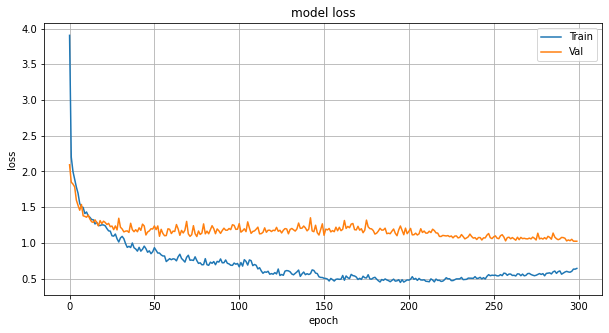

In [82]:
# summarize history for loss
plt.figure(figsize=(10,5))
plt.plot(some.history['loss'])
plt.plot(some.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='best')
#plt.xlim([100,None])
#plt.ylim([None,100])
plt.grid()
plt.show()

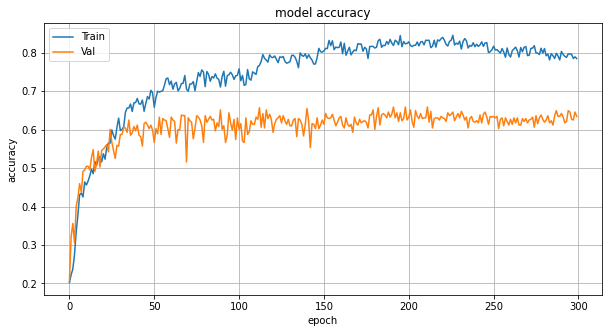

In [83]:
# summarize history for accuracy
plt.figure(figsize=(10,5))
plt.plot(some.history['accuracy'])
plt.plot(some.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='best')
#plt.xlim([100,None])
#plt.ylim([None,100])
plt.grid()
plt.show()

In [84]:
# Training
#actual = y_smote[tr_idx]
#predicted = np.argmax(Tpreds, axis=1) + 1 

# Validation
#actual = y[val_idx]
#predicted = np.argmax(Vpreds, axis=1) + 1

#Test
actual = y_test
predicted = np.argmax(Testpreds/NFOLD, axis=1) + 1 # labels start from 1, not 0

# confusion matrix
matrix = confusion_matrix(actual,predicted, labels=range(1,10))
print('Confusion matrix : \n',matrix)

# classification report for precision, recall f1-score and accuracy
matrix = classification_report(actual,predicted,labels=range(1,10))
print('Classification report : \n',matrix)

Confusion matrix : 
 [[ 79   2   0  23   5   1   4   0   0]
 [  4  43   0   4   0   0  40   0   0]
 [  0   0   0   4   1   0  13   0   0]
 [ 21   1   0 104   2   2   7   0   0]
 [ 17   2   0   4   9   3  13   0   0]
 [  9   1   0   2   2  29  12   0   0]
 [  0  18   0   6   0   1 166   0   0]
 [  1   0   0   0   0   0   3   0   0]
 [  0   0   0   2   0   0   1   0   4]]
Classification report : 
               precision    recall  f1-score   support

           1       0.60      0.69      0.64       114
           2       0.64      0.47      0.54        91
           3       0.00      0.00      0.00        18
           4       0.70      0.76      0.73       137
           5       0.47      0.19      0.27        48
           6       0.81      0.53      0.64        55
           7       0.64      0.87      0.74       191
           8       0.00      0.00      0.00         4
           9       1.00      0.57      0.73         7

    accuracy                           0.65       665
   ma